In [1]:
# connecting to Google.Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# specifing to the directory that we are going to save the dataset there.
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
# going to the that directory.
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# downloading the chest-xray-pneumonia dataset from kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# unziping the dataset and saving it to the specified directory.
!unzip -q 'chest-xray-pneumonia.zip'

In [5]:
# importing required libraries.
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch
from pathlib import Path
import torch.nn.functional as F
from PIL import Image
import torchvision
import torch.nn as nn
import tensorflow as tf
import numpy as np
import torch.optim as optim
import pandas as pd
from torchvision.datasets import ImageFolder

In [6]:
# specifing some constants needed for our work.
image_size = 216
batch_size = 16
num_epochs = 40
learning_rate = 0.001

In [7]:
# this is a class for making our dataset ready for further uses.
# it loads the datset from a given path and applying transforms on it if there is any.
# it gives normal images label 0 and anomalies label 1.
# this class also crop images so that their size be image_size.
class MyDataset(object):
    def __init__(self, root, split, transforms=None):
        self.root = root
        self.transforms = transforms
        self.data_dir = os.path.join(root, split)
        self.imgs = []
        for i in list(sorted(os.listdir(os.path.join(self.data_dir, 'NORMAL')))):
          if i[-4:] == "jpeg":
            self.imgs.append((i, 'NORMAL'))
        for i  in list(sorted(os.listdir(os.path.join(self.data_dir, 'PNEUMONIA')))):
          if i[-4:] == "jpeg":
            self.imgs.append((i, 'PNEUMONIA')) 
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx][1], self.imgs[idx][0])
        img = Image.open(img_path).convert('RGB').resize((image_size, image_size))
        img = np.moveaxis(np.array(img)/255.0, -1, 0)
        label = 0 if self.imgs[idx][1] == 'NORMAL' else 1
        if self.transforms is not None:
            img= self.transforms(torch.from_numpy(img).float())
        return img, label

In [8]:
# these are three transforms for our training dataset.
train_transforms = transforms.RandomApply(torch.nn.ModuleList([
      transforms.RandomHorizontalFlip(p=0.7),
      transforms.RandomVerticalFlip(p=0.7),
      transforms.RandomPerspective(p=0.7)]), p=0.5)

In [9]:
# making train, test and validation dataset ready with our defined class above.
root = "chest_xray/chest_xray"
train_data = MyDataset(root, 'train', train_transforms)
test_data = MyDataset(root, 'test')
val_data = MyDataset(root, 'val')

In [10]:
# loading datasets with torch.utils.data.DataLoader with a defined batch_size.

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size, True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size, True)

Model with DropOut

In [12]:
def convx(in_channels, out_channels, kernel_size, stride, padding=0):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = convx(in_channels, out_channels, kernel_size, 3, 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convx(out_channels, out_channels, kernel_size, 1, 3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(dim=1)
        self.downsample = downsample
        self.dropout = nn.Dropout(0.4) 

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.soft(out)
        out = self.dropout(out)
        return out

class ResNet(nn.Module):
    def __init__(self, paddings, num_classes = 2):
        super(ResNet, self).__init__()
        self.in_channels = 3
        self.block1 = self.make_layer(16, 7, paddings[0])
        self.block2 = self.make_layer(32, 5, paddings[1])
        self.block3 = self.make_layer(64, 3, paddings[2])
        self.fc = nn.Linear(9216, num_classes)
        
    def make_layer(self, out_channels, kernel_size, pad):
        downsample = None
        if self.in_channels != out_channels: 
            downsample = nn.Sequential(convx(self.in_channels, out_channels, kernel_size, 3, pad), nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, kernel_size, downsample))
        self.in_channels = out_channels
        return nn.Sequential(* layers)
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
model = ResNet([0, 2, 6])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
curr_lr = learning_rate
min_valid_loss = np.inf

step: 0 of epoch: 1 train_loss: 11.111175537109375
step: 50 of epoch: 1 train_loss: 9.583984375
step: 100 of epoch: 1 train_loss: 3.1891937255859375
step: 150 of epoch: 1 train_loss: 7.082729339599609
step: 200 of epoch: 1 train_loss: 2.4278388023376465
step: 250 of epoch: 1 train_loss: 4.863508224487305
step: 300 of epoch: 1 train_loss: 1.0249277353286743
Epoch 1 		 Train Loss: 4.361318500495396
step: 0 of epoch: 2 train_loss: 1.751366138458252
step: 50 of epoch: 2 train_loss: 1.5407891273498535
step: 100 of epoch: 2 train_loss: 2.483245611190796
step: 150 of epoch: 2 train_loss: 1.4254168272018433
step: 200 of epoch: 2 train_loss: 0.8409031629562378
step: 250 of epoch: 2 train_loss: 3.355459213256836
step: 300 of epoch: 2 train_loss: 1.9262642860412598
Epoch 2 		 Train Loss: 2.7019594953469706
step: 0 of epoch: 3 train_loss: 3.649000406265259
step: 50 of epoch: 3 train_loss: 0.49754682183265686
step: 100 of epoch: 3 train_loss: 0.7863806486129761
step: 150 of epoch: 3 train_loss: 1.1

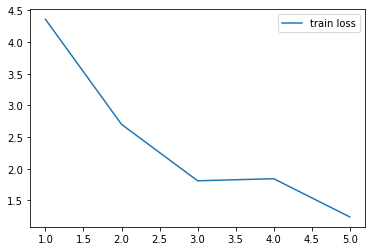

step: 0 of epoch: 6 train_loss: 1.027295470237732
step: 50 of epoch: 6 train_loss: 0.274689644575119
step: 100 of epoch: 6 train_loss: 0.15647976100444794
step: 150 of epoch: 6 train_loss: 0.31305015087127686
step: 200 of epoch: 6 train_loss: 1.4296956062316895
step: 250 of epoch: 6 train_loss: 0.03835554048418999
step: 300 of epoch: 6 train_loss: 0.3606654107570648
Epoch 6 		 Train Loss: 0.9660255172649866
step: 0 of epoch: 7 train_loss: 1.8726927042007446
step: 50 of epoch: 7 train_loss: 0.7635912895202637
step: 100 of epoch: 7 train_loss: 0.30508649349212646
step: 150 of epoch: 7 train_loss: 0.7100910544395447
step: 200 of epoch: 7 train_loss: 0.9821178913116455
step: 250 of epoch: 7 train_loss: 0.12842689454555511
step: 300 of epoch: 7 train_loss: 0.5118576288223267
Epoch 7 		 Train Loss: 0.8206158534115169
step: 0 of epoch: 8 train_loss: 0.07271135598421097
step: 50 of epoch: 8 train_loss: 0.43337613344192505
step: 100 of epoch: 8 train_loss: 2.3066625595092773
step: 150 of epoch:

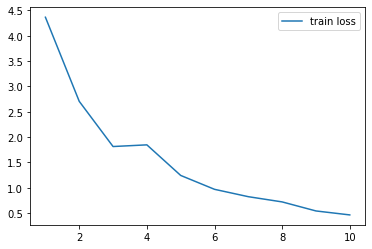

step: 0 of epoch: 11 train_loss: 0.07161714136600494
step: 50 of epoch: 11 train_loss: 0.15812894701957703
step: 100 of epoch: 11 train_loss: 0.6198684573173523
step: 200 of epoch: 11 train_loss: 1.2363457679748535
step: 250 of epoch: 11 train_loss: 0.2606774866580963
step: 300 of epoch: 11 train_loss: 0.16550466418266296
Epoch 11 		 Train Loss: 0.41389325261973076
step: 0 of epoch: 12 train_loss: 0.14338238537311554
step: 50 of epoch: 12 train_loss: 0.4127209782600403
step: 100 of epoch: 12 train_loss: 0.13481511175632477
step: 150 of epoch: 12 train_loss: 0.771786093711853
step: 200 of epoch: 12 train_loss: 0.2795755863189697
step: 250 of epoch: 12 train_loss: 0.1092260405421257
step: 300 of epoch: 12 train_loss: 0.520715594291687
Epoch 12 		 Train Loss: 0.37074094813637026
step: 0 of epoch: 13 train_loss: 0.9715893268585205
step: 50 of epoch: 13 train_loss: 0.5947081446647644
step: 100 of epoch: 13 train_loss: 0.10719908773899078
step: 150 of epoch: 13 train_loss: 0.2243064343929290

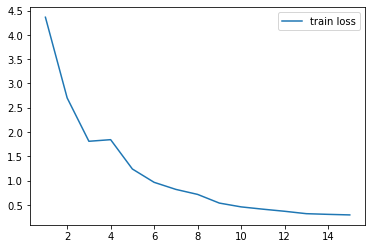

step: 0 of epoch: 16 train_loss: 0.5288727283477783
step: 50 of epoch: 16 train_loss: 0.12295080721378326
step: 100 of epoch: 16 train_loss: 0.43737730383872986
step: 150 of epoch: 16 train_loss: 0.1119847297668457
step: 200 of epoch: 16 train_loss: 0.2067682296037674
step: 250 of epoch: 16 train_loss: 0.45124247670173645
step: 300 of epoch: 16 train_loss: 0.22716127336025238
Epoch 16 		 Train Loss: 0.28526740139521706
step: 0 of epoch: 17 train_loss: 0.135066419839859
step: 50 of epoch: 17 train_loss: 0.5375837087631226
step: 100 of epoch: 17 train_loss: 0.08437255769968033
step: 150 of epoch: 17 train_loss: 1.5521141290664673
step: 200 of epoch: 17 train_loss: 0.23329618573188782
step: 250 of epoch: 17 train_loss: 0.02224503457546234
step: 300 of epoch: 17 train_loss: 0.22776025533676147
Epoch 17 		 Train Loss: 0.2681793788622242
step: 0 of epoch: 18 train_loss: 0.11319803446531296
step: 50 of epoch: 18 train_loss: 0.22972659766674042
step: 100 of epoch: 18 train_loss: 0.080769754946

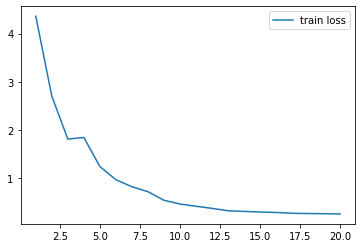

step: 0 of epoch: 21 train_loss: 0.18803249299526215
step: 50 of epoch: 21 train_loss: 0.796858012676239
step: 100 of epoch: 21 train_loss: 0.3001667261123657
step: 150 of epoch: 21 train_loss: 0.04881686344742775
step: 200 of epoch: 21 train_loss: 0.436452716588974
step: 250 of epoch: 21 train_loss: 0.12330219149589539
step: 300 of epoch: 21 train_loss: 0.16741283237934113
Epoch 21 		 Train Loss: 0.24868601765997844
step: 0 of epoch: 22 train_loss: 0.17294366657733917
step: 50 of epoch: 22 train_loss: 0.1373475193977356
step: 100 of epoch: 22 train_loss: 0.10932520031929016
step: 150 of epoch: 22 train_loss: 0.1537916213274002
step: 200 of epoch: 22 train_loss: 0.048831939697265625
step: 250 of epoch: 22 train_loss: 0.05055971443653107
step: 300 of epoch: 22 train_loss: 0.09827283769845963
Epoch 22 		 Train Loss: 0.24729744374160684
step: 0 of epoch: 23 train_loss: 0.4108842611312866
step: 50 of epoch: 23 train_loss: 0.20782049000263214
step: 100 of epoch: 23 train_loss: 0.29283821582

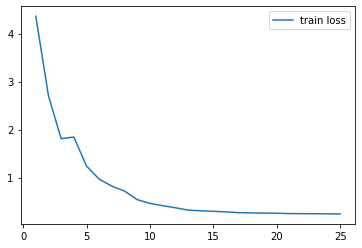

step: 0 of epoch: 26 train_loss: 0.4232560992240906
step: 50 of epoch: 26 train_loss: 0.38491395115852356
step: 100 of epoch: 26 train_loss: 0.14833246171474457
step: 150 of epoch: 26 train_loss: 0.20268762111663818
step: 200 of epoch: 26 train_loss: 0.2280215620994568
step: 250 of epoch: 26 train_loss: 0.24836355447769165
step: 300 of epoch: 26 train_loss: 0.18848133087158203
Epoch 26 		 Train Loss: 0.2413660575481463
step: 0 of epoch: 27 train_loss: 0.056967489421367645
step: 50 of epoch: 27 train_loss: 0.25096461176872253
step: 100 of epoch: 27 train_loss: 0.24047452211380005
step: 150 of epoch: 27 train_loss: 0.09531368315219879
step: 200 of epoch: 27 train_loss: 0.15558449923992157
step: 250 of epoch: 27 train_loss: 0.19955867528915405
step: 300 of epoch: 27 train_loss: 0.08500004559755325
Epoch 27 		 Train Loss: 0.240832651496802
step: 0 of epoch: 28 train_loss: 0.0721384733915329
step: 50 of epoch: 28 train_loss: 0.47771918773651123
step: 100 of epoch: 28 train_loss: 0.035908013

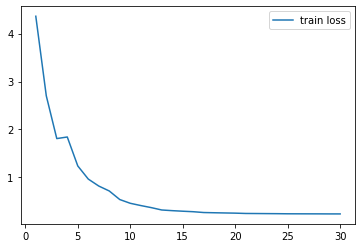

step: 0 of epoch: 31 train_loss: 0.10126043856143951
step: 50 of epoch: 31 train_loss: 0.48451709747314453
step: 100 of epoch: 31 train_loss: 0.2563243508338928
step: 150 of epoch: 31 train_loss: 0.14019697904586792
step: 200 of epoch: 31 train_loss: 0.18959566950798035
step: 250 of epoch: 31 train_loss: 0.19206377863883972
step: 300 of epoch: 31 train_loss: 0.12836489081382751
Epoch 31 		 Train Loss: 0.23910527624206995
step: 0 of epoch: 32 train_loss: 0.2239888310432434
step: 50 of epoch: 32 train_loss: 0.4244733154773712
step: 100 of epoch: 32 train_loss: 0.1270492523908615
step: 150 of epoch: 32 train_loss: 0.11008691787719727
step: 200 of epoch: 32 train_loss: 0.1283470094203949
step: 250 of epoch: 32 train_loss: 0.07214277982711792
step: 300 of epoch: 32 train_loss: 0.11372433602809906
Epoch 32 		 Train Loss: 0.2389003819774585
step: 0 of epoch: 33 train_loss: 0.1902277171611786
step: 50 of epoch: 33 train_loss: 0.2757217288017273
step: 100 of epoch: 33 train_loss: 0.115680575370

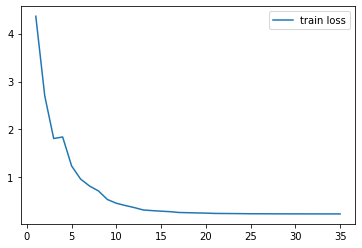

step: 0 of epoch: 36 train_loss: 0.1026843786239624
step: 50 of epoch: 36 train_loss: 0.026404336094856262
step: 100 of epoch: 36 train_loss: 0.20044544339179993
step: 150 of epoch: 36 train_loss: 0.11211572587490082
step: 200 of epoch: 36 train_loss: 0.2110554724931717
step: 250 of epoch: 36 train_loss: 0.03715391084551811
step: 300 of epoch: 36 train_loss: 0.4963669776916504
Epoch 36 		 Train Loss: 0.2384462929944982
step: 0 of epoch: 37 train_loss: 0.6019651889801025
step: 50 of epoch: 37 train_loss: 0.4007227122783661
step: 100 of epoch: 37 train_loss: 0.1352725774049759
step: 150 of epoch: 37 train_loss: 0.2726082503795624
step: 200 of epoch: 37 train_loss: 0.21897253394126892
step: 250 of epoch: 37 train_loss: 0.18853497505187988
step: 300 of epoch: 37 train_loss: 0.3025561571121216
Epoch 37 		 Train Loss: 0.2383532984485061
step: 0 of epoch: 38 train_loss: 0.9057278633117676
step: 50 of epoch: 38 train_loss: 0.08175502717494965
step: 100 of epoch: 38 train_loss: 0.30653265118598

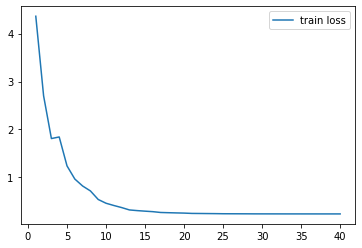

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

train_losses = []
validation_losses = []
eps = []
for epoch in range(num_epochs):
  eps.append(epoch+1)
  train_loss = 0.0
  for i, (images, labels) in enumerate(train_dataloader):
      images, labels = images.to(device), labels.to(device)
      labels = F.one_hot(labels, 2)
      optimizer.zero_grad()
      outputs = model(images.float())
      labels = labels.type_as(outputs)
      loss = F.binary_cross_entropy_with_logits(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      if i % 50 == 0:
        print("step: "+ str(i) + " of epoch: " + str(epoch+1) +" train_loss: " + str(loss.item() * images.size(0)))
  

  train_losses.append(train_loss/len(train_dataloader))
  print(f'Epoch {epoch+1} \t\t Train Loss: {\
    train_loss / len(train_dataloader)}')
  
  valid_loss = 0.0
  model.eval()
  for images, labels in val_dataloader:
      images, labels = images.cuda(), labels.cuda()
      labels = F.one_hot(labels, 2)
      target = model(images.float())
      labels = labels.type_as(outputs)
      loss = F.binary_cross_entropy_with_logits(outputs, labels)
      valid_loss += loss.item() * images.size(0)
  validation_losses.append(valid_loss/len(val_dataloader))

  if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch+1} \t\t Validation Loss: {\
        valid_loss / len(val_dataloader)}')
      plt.plot(eps, train_losses)
      plt.legend(["train loss"])
      plt.show()
      
  if (epoch + 1) % 4 == 0:
      curr_lr = curr_lr / 3.
      update_lr(optimizer, curr_lr)
      
  if min_valid_loss > valid_loss:
    min_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_model.pth')

In [19]:
model = ResNet([0, 2, 6]).to("cuda")
model.load_state_dict(torch.load("saved_model.pth"))
model.eval()
with torch.no_grad():
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    predictions = []
    ll = []
    for data in test_dataloader:
        images, labels = data
        y_hot = F.one_hot(labels, 2)
        images, y_hot = images.to(device), y_hot.to(device)
        outputs = model(images.float())
        y_hot = y_hot.type_as(outputs)
        _, preds = torch.max(outputs, 1)
        for k in preds.cpu().numpy():
            predictions.append(k)
        for k in labels.cpu().numpy():
            ll.append(k)
        total += labels.size(0)
        correct += (labels.to("cuda") == preds).sum().item()
        loss =  F.binary_cross_entropy_with_logits(outputs, y_hot)
        test_loss += loss.item() * images.size(0)
    print("Test Loss: " + str(test_loss/len(test_dataloader)))
    print("Accuracy on test dataset: " + str(correct/total))
    print("Confusion matrix of test dataset is: " + str(confusion_matrix(ll, predictions)))

Test Loss: 13.848788661798702
Accuracy on test dataset: 0.8974358974358974
Confusion matrix of test dataset is: [[ 172 62] 
[  2 388]]


Model without DropOut

In [11]:
def convx(in_channels, out_channels, kernel_size, stride, padding=0):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = convx(in_channels, out_channels, kernel_size, 3, 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convx(out_channels, out_channels, kernel_size, 1, 3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(dim=1)
        self.downsample = downsample
        # self.dropout = nn.Dropout(0.4) 

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.soft(out)
        # out = self.dropout(out)
        return out

class ResNet(nn.Module):
    def __init__(self, paddings, num_classes = 2):
        super(ResNet, self).__init__()
        self.in_channels = 3
        self.block1 = self.make_layer(16, 7, paddings[0])
        self.block2 = self.make_layer(32, 5, paddings[1])
        self.block3 = self.make_layer(64, 3, paddings[2])
        self.fc = nn.Linear(9216, num_classes)
        
    def make_layer(self, out_channels, kernel_size, pad):
        downsample = None
        if self.in_channels != out_channels: 
            downsample = nn.Sequential(convx(self.in_channels, out_channels, kernel_size, 3, pad), nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, kernel_size, downsample))
        self.in_channels = out_channels
        return nn.Sequential(* layers)
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
model = ResNet([0, 2, 6])
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
curr_lr = learning_rate
min_valid_loss = np.inf

step: 0 of epoch: 1 train_loss: 11.110100746154785
step: 50 of epoch: 1 train_loss: 4.2255730628967285
step: 100 of epoch: 1 train_loss: 1.8811638355255127
step: 150 of epoch: 1 train_loss: 1.098260760307312
step: 200 of epoch: 1 train_loss: 0.726036787033081
step: 250 of epoch: 1 train_loss: 6.771018981933594
step: 300 of epoch: 1 train_loss: 0.49374377727508545
Epoch 1 		 Train Loss: 3.114320259792673
step: 0 of epoch: 2 train_loss: 11.956233024597168
step: 50 of epoch: 2 train_loss: 5.3148345947265625
step: 100 of epoch: 2 train_loss: 4.181025505065918
step: 150 of epoch: 2 train_loss: 2.5282411575317383
step: 200 of epoch: 2 train_loss: 1.8577555418014526
step: 250 of epoch: 2 train_loss: 3.668917179107666
step: 300 of epoch: 2 train_loss: 1.492607593536377
Epoch 2 		 Train Loss: 3.7174314470744574
step: 0 of epoch: 3 train_loss: 4.992262840270996
step: 50 of epoch: 3 train_loss: 3.406445264816284
step: 100 of epoch: 3 train_loss: 5.177135467529297
step: 150 of epoch: 3 train_loss:

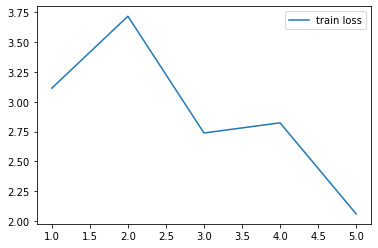

step: 0 of epoch: 6 train_loss: 3.8119916915893555
step: 50 of epoch: 6 train_loss: 1.9186246395111084
step: 100 of epoch: 6 train_loss: 0.3512640595436096
step: 150 of epoch: 6 train_loss: 1.1566293239593506
step: 200 of epoch: 6 train_loss: 1.4016565084457397
step: 250 of epoch: 6 train_loss: 1.9285868406295776
step: 300 of epoch: 6 train_loss: 0.7843197584152222
Epoch 6 		 Train Loss: 1.7274071420857147
step: 0 of epoch: 7 train_loss: 0.5334954261779785
step: 50 of epoch: 7 train_loss: 2.167703866958618
step: 100 of epoch: 7 train_loss: 1.1731235980987549
step: 150 of epoch: 7 train_loss: 0.482147753238678
step: 200 of epoch: 7 train_loss: 2.6471433639526367
step: 250 of epoch: 7 train_loss: 2.3838281631469727
step: 300 of epoch: 7 train_loss: 0.8307613730430603
Epoch 7 		 Train Loss: 1.598313230266966
step: 0 of epoch: 8 train_loss: 2.599612236022949
step: 50 of epoch: 8 train_loss: 0.955375075340271
step: 100 of epoch: 8 train_loss: 1.3468177318572998
step: 150 of epoch: 8 train_l

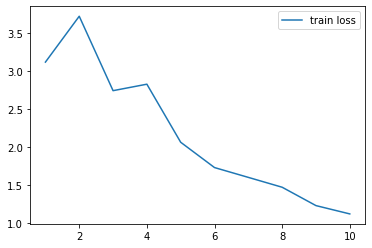

step: 0 of epoch: 11 train_loss: 0.4094056189060211
step: 50 of epoch: 11 train_loss: 1.8971480131149292
step: 100 of epoch: 11 train_loss: 0.6984108686447144
step: 150 of epoch: 11 train_loss: 0.30442649126052856
step: 200 of epoch: 11 train_loss: 1.0905860662460327
step: 250 of epoch: 11 train_loss: 1.900491714477539
step: 300 of epoch: 11 train_loss: 1.7516182661056519
Epoch 11 		 Train Loss: 1.004062942909134
step: 0 of epoch: 12 train_loss: 0.26406702399253845
step: 50 of epoch: 12 train_loss: 1.3809183835983276
step: 100 of epoch: 12 train_loss: 0.503076434135437
step: 150 of epoch: 12 train_loss: 0.6386374235153198
step: 200 of epoch: 12 train_loss: 0.9242559671401978
step: 250 of epoch: 12 train_loss: 0.24966514110565186
step: 300 of epoch: 12 train_loss: 0.3396278917789459
Epoch 12 		 Train Loss: 0.9313193968171539
step: 0 of epoch: 13 train_loss: 4.088217735290527
step: 50 of epoch: 13 train_loss: 0.8128550052642822
step: 100 of epoch: 13 train_loss: 1.2719568014144897
step: 

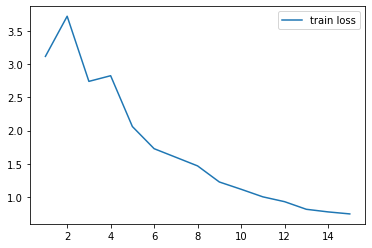

step: 0 of epoch: 16 train_loss: 0.7673250436782837
step: 50 of epoch: 16 train_loss: 0.3053167164325714
step: 100 of epoch: 16 train_loss: 0.9442304372787476
step: 150 of epoch: 16 train_loss: 0.903649091720581
step: 200 of epoch: 16 train_loss: 0.15709686279296875
step: 250 of epoch: 16 train_loss: 0.8327545523643494
step: 300 of epoch: 16 train_loss: 0.8646787405014038
Epoch 16 		 Train Loss: 0.7253035268420639
step: 0 of epoch: 17 train_loss: 0.5049425363540649
step: 50 of epoch: 17 train_loss: 1.5435709953308105
step: 100 of epoch: 17 train_loss: 0.3130671977996826
step: 150 of epoch: 17 train_loss: 0.40403982996940613
step: 200 of epoch: 17 train_loss: 0.4545893371105194
step: 250 of epoch: 17 train_loss: 0.2585768401622772
step: 300 of epoch: 17 train_loss: 1.569037675857544
Epoch 17 		 Train Loss: 0.688379945393446
step: 0 of epoch: 18 train_loss: 1.7109884023666382
step: 50 of epoch: 18 train_loss: 0.35351359844207764
step: 100 of epoch: 18 train_loss: 0.5834267139434814
step:

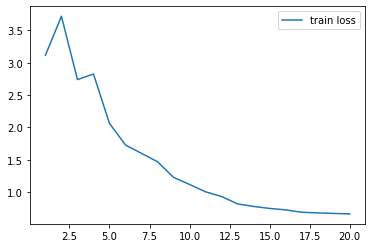

step: 0 of epoch: 21 train_loss: 0.3251760005950928
step: 50 of epoch: 21 train_loss: 1.9654881954193115
step: 100 of epoch: 21 train_loss: 0.12709543108940125
step: 150 of epoch: 21 train_loss: 0.3262608051300049
step: 200 of epoch: 21 train_loss: 0.13415853679180145
step: 250 of epoch: 21 train_loss: 0.31772518157958984
step: 300 of epoch: 21 train_loss: 0.10217802226543427
Epoch 21 		 Train Loss: 0.6486775453025304
step: 0 of epoch: 22 train_loss: 0.172143816947937
step: 50 of epoch: 22 train_loss: 0.21431678533554077
step: 100 of epoch: 22 train_loss: 0.5490210056304932
step: 150 of epoch: 22 train_loss: 0.883479118347168
step: 200 of epoch: 22 train_loss: 1.1948456764221191
step: 250 of epoch: 22 train_loss: 0.3856402039527893
step: 300 of epoch: 22 train_loss: 1.9433562755584717
Epoch 22 		 Train Loss: 0.6458858995601261
step: 0 of epoch: 23 train_loss: 1.491032600402832
step: 50 of epoch: 23 train_loss: 0.5746293067932129
step: 100 of epoch: 23 train_loss: 0.2106117606163025
ste

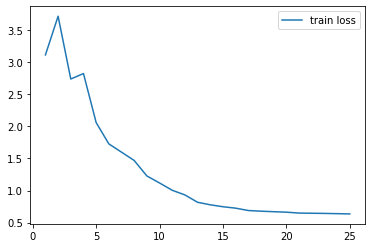

step: 0 of epoch: 26 train_loss: 0.10981127619743347
step: 50 of epoch: 26 train_loss: 0.5164788365364075
step: 100 of epoch: 26 train_loss: 0.6433833837509155
step: 150 of epoch: 26 train_loss: 1.6871163845062256
step: 200 of epoch: 26 train_loss: 0.8923040628433228
step: 250 of epoch: 26 train_loss: 1.0775773525238037
step: 300 of epoch: 26 train_loss: 0.3131418228149414
Epoch 26 		 Train Loss: 0.6343105335839869
step: 0 of epoch: 27 train_loss: 0.520794153213501
step: 50 of epoch: 27 train_loss: 0.405331015586853
step: 100 of epoch: 27 train_loss: 0.6821717023849487
step: 150 of epoch: 27 train_loss: 0.07754384726285934
step: 200 of epoch: 27 train_loss: 0.23999139666557312
step: 250 of epoch: 27 train_loss: 2.9933457374572754
step: 300 of epoch: 27 train_loss: 0.6454689502716064
Epoch 27 		 Train Loss: 0.6332516050754697
step: 0 of epoch: 28 train_loss: 1.3851964473724365
step: 50 of epoch: 28 train_loss: 0.2897091209888458
step: 100 of epoch: 28 train_loss: 0.32467976212501526
ste

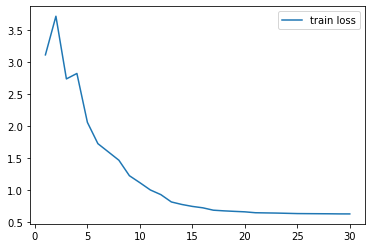

step: 0 of epoch: 31 train_loss: 0.16558092832565308
step: 50 of epoch: 31 train_loss: 0.7701253890991211
step: 100 of epoch: 31 train_loss: 1.2312581539154053
step: 150 of epoch: 31 train_loss: 0.30525314807891846
step: 200 of epoch: 31 train_loss: 0.2453698217868805
step: 250 of epoch: 31 train_loss: 0.4414498209953308
step: 300 of epoch: 31 train_loss: 0.5478980541229248
Epoch 31 		 Train Loss: 0.6297901886875278
step: 0 of epoch: 32 train_loss: 2.236499547958374
step: 50 of epoch: 32 train_loss: 0.026198208332061768
step: 100 of epoch: 32 train_loss: 0.43545469641685486
step: 150 of epoch: 32 train_loss: 0.05293969437479973
step: 200 of epoch: 32 train_loss: 0.272431880235672
step: 250 of epoch: 32 train_loss: 0.3937895596027374
step: 300 of epoch: 32 train_loss: 0.25047120451927185
Epoch 32 		 Train Loss: 0.6294021187750108
step: 0 of epoch: 33 train_loss: 0.927192747592926
step: 50 of epoch: 33 train_loss: 0.8036581873893738
step: 100 of epoch: 33 train_loss: 0.3470293879508972
s

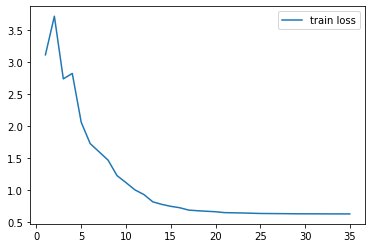

step: 0 of epoch: 36 train_loss: 0.4937055706977844
step: 50 of epoch: 36 train_loss: 0.09615275263786316
step: 100 of epoch: 36 train_loss: 0.3095288574695587
step: 150 of epoch: 36 train_loss: 0.4954717755317688
step: 200 of epoch: 36 train_loss: 0.43002790212631226
step: 250 of epoch: 36 train_loss: 0.41917285323143005
step: 300 of epoch: 36 train_loss: 0.3361585736274719
Epoch 36 		 Train Loss: 0.6284395052817153
step: 0 of epoch: 37 train_loss: 1.2920947074890137
step: 50 of epoch: 37 train_loss: 0.2025812566280365
step: 100 of epoch: 37 train_loss: 0.46175917983055115
step: 150 of epoch: 37 train_loss: 1.0466604232788086
step: 200 of epoch: 37 train_loss: 0.3145468831062317
step: 250 of epoch: 37 train_loss: 0.13350795209407806
step: 300 of epoch: 37 train_loss: 0.22800254821777344
Epoch 37 		 Train Loss: 0.6282803699876999
step: 0 of epoch: 38 train_loss: 0.9811955690383911
step: 50 of epoch: 38 train_loss: 0.7152453064918518
step: 100 of epoch: 38 train_loss: 0.6853064894676208

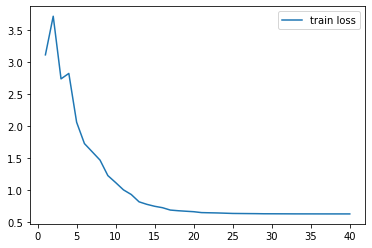

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

train_losses = []
validation_losses = []
eps = []
for epoch in range(num_epochs):
  eps.append(epoch+1)
  train_loss = 0.0
  for i, (images, labels) in enumerate(train_dataloader):
      images, labels = images.to(device), labels.to(device)
      labels = F.one_hot(labels, 2)
      optimizer.zero_grad()
      outputs = model(images.float())
      labels = labels.type_as(outputs)
      loss = F.binary_cross_entropy_with_logits(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      if i % 50 == 0:
        print("step: "+ str(i) + " of epoch: " + str(epoch+1) +" train_loss: " + str(loss.item() * images.size(0)))
  

  train_losses.append(train_loss/len(train_dataloader))
  print(f'Epoch {epoch+1} \t\t Train Loss: {\
    train_loss / len(train_dataloader)}')
  
  valid_loss = 0.0
  model.eval()
  for images, labels in val_dataloader:
      images, labels = images.to(device), labels.to(device)
      labels = F.one_hot(labels, 2)
      target = model(images.float())
      labels = labels.type_as(outputs)
      loss = F.binary_cross_entropy_with_logits(outputs, labels)
      valid_loss += loss.item() * images.size(0)
  validation_losses.append(valid_loss/len(val_dataloader))

  if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch+1} \t\t Validation Loss: {\
        valid_loss / len(val_dataloader)}')
      plt.plot(eps, train_losses)
      plt.legend(["train loss"])
      plt.show()
      
  if (epoch + 1) % 4 == 0:
      curr_lr = curr_lr / 3.
      update_lr(optimizer, curr_lr)
      
  if min_valid_loss > valid_loss:
    min_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_model1.pth')

In [3]:
model = ResNet([0, 2, 6]).to("cuda")
model.load_state_dict(torch.load("saved_model.pth"))
model.eval()
with torch.no_grad():
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    predictions = []
    ll = []
    for data in test_dataloader:
        images, labels = data
        y_hot = F.one_hot(labels, 2)
        images, y_hot = images.to(device), y_hot.to(device)
        outputs = model(images.float())
        y_hot = y_hot.type_as(outputs)
        _, preds = torch.max(outputs, 1)
        for k in preds.cpu().numpy():
            predictions.append(k)
        for k in labels.cpu().numpy():
            ll.append(k)
        total += labels.size(0)
        correct += (labels.to("cuda") == preds).sum().item()
        loss =  F.binary_cross_entropy_with_logits(outputs, y_hot)
        test_loss += loss.item() * images.size(0)
    print("Test Loss: " + str(test_loss/len(test_dataloader)))
    print("Accuracy on test dataset: " + str(correct/total))
    print("Confusion matrix of test dataset is: " + str(confusion_matrix(ll, predictions)))

Test Loss: 18.85090729288566
Accuracy on test dataset: 0.8525641025641025
Confusion matrix of test dataset is: [[ 151 83] 
 [  9 381]]
